# Demo of STARCOP models on AVIRIS data

Demos with model loading and inference on AVIRIS data from the test set.

In [ ]:
!pip install rasterio
!pip install --quiet --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 46.7 MB/s eta 0:00:00


In [ ]:
# Clone the repository:
!git clone https://github.com/spaceml-org/STARCOP.git

In [ ]:
# Data:
# STARCOP_mini.zip with 261 MB
# this is a mini dataset subset (the full one is too large for Colab demos)
!gdown https://drive.google.com/uc?id=1Qw96Drmk2jzBYSED0YPEUyuc2DnBechl -O STARCOP_mini.zip

# Models:
!gdown https://drive.google.com/uc?id=1TXFlAHO_eRdfbJGLNNt3KY0lJqjm3fdX -O multistarcop_varon.zip
!gdown https://drive.google.com/uc?id=1Kvnc_lOBn4z-xO1HFRyLZOMEldXWQvql -O hyperstarcop_magic_rgb.zip

Downloading...
From (uriginal): https://drive.google.com/uc?id=1Qw96Drmk2jzBYSED0YPEUyuc2DnBechl
From (redirected): https://drive.google.com/uc?id=1Qw96Drmk2jzBYSED0YPEUyuc2DnBechl&confirm=t&uuid=37283bc8-b552-4e8e-9167-7b2a6477e843
To: /content/STARCOP_mini.zip
100% 274M/274M [00:02<00:00, 92.8MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1TXFlAHO_eRdfbJGLNNt3KY0lJqjm3fdX
From (redirected): https://drive.google.com/uc?id=1TXFlAHO_eRdfbJGLNNt3KY0lJqjm3fdX&confirm=t&uuid=89f3ae0f-ba35-4f6f-be55-972e361a4008
To: /content/multistarcop_varon.zip
100% 73.5M/73.5M [00:01<00:00, 71.8MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1Kvnc_lOBn4z-xO1HFRyLZOMEldXWQvql
From (redirected): https://drive.google.com/uc?id=1Kvnc_lOBn4z-xO1HFRyLZOMEldXWQvql&confirm=t&uuid=ed207471-8f4c-4fbb-8f01-19fd3e49a7ed
To: /content/hyperstarcop_magic_rgb.zip
100% 73.3M/73.3M [00:01<00:00, 73.1MB/s]


In [ ]:
!unzip -q STARCOP_mini.zip
!unzip -q multistarcop_varon.zip
!unzip -q hyperstarcop_magic_rgb.zip
# clean-up
!rm *.zip

In [ ]:
!ls

hyperstarcop_magic_rgb	multistarcop_varon  sample_data  STARCOP  STARCOP_mini


In [ ]:
%cd /content/STARCOP

/content/STARCOP


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 23.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━

In [ ]:
# additional libraries and exact versions:
!pip install git+https://github.com/spaceml-org/georeader.git
!pip install torchmetrics==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/spaceml-org/georeader.git to /tmp/pip-req-build-2rb8ew4z
  Running command git clone --filter=blob:none --quiet https://github.com/spaceml-org/georeader.git /tmp/pip-req-build-2rb8ew4z
  Resolved https://github.com/spaceml-org/georeader.git to commit 61150ea6ee9ba300f3dcc1429f680aad30d737a2
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torchmetrics-0.10.0-py3-none-any.whl (529 kB)
  Attempting uninstall: torchmetrics
    Found existing installation: torchmetrics 0.11.4
    Uninstalling torchmetrics-0.11.4:
      Successfully uninstalled torchmetrics-0.11.4


In [ ]:
assert False
# please restart the runtime with the button above ^

In [ ]:
%cd /content/STARCOP

/content/STARCOP


In [ ]:
import omegaconf
import pylab as plt
import torch
import omegaconf
import fsspec
import os
import json
import pandas as pd
import numpy as np
from starcop.torch_utils import to_device
import starcop.plot as starcoplot
from mpl_toolkits.axes_grid1 import make_axes_locatable

from starcop.data.datamodule import Permian2019DataModule
from starcop.models.model_module import ModelModule
from starcop.validation import run_validation

device = torch.device("cuda:0")
fs = fsspec.filesystem("gs")
config_general = omegaconf.OmegaConf.load("scripts/configs/config.yaml")
root_folder = "/content/STARCOP_mini"

## HyperSTARCOP

In [ ]:
hsi_model_path = "/content/hyperstarcop_magic_rgb/final_checkpoint_model.ckpt"
hsi_config_path = "/content/hyperstarcop_magic_rgb/config.yaml"

In [ ]:
def load_model_with_datamodule(model_path, config_path):
    config_model = omegaconf.OmegaConf.load(config_path)
    config = omegaconf.OmegaConf.merge(config_general, config_model)

    import ast
    dataset_dict = ast.literal_eval(config_model['_content']['value']['dataset'])
    dataset_dict['root_folder'] = root_folder
    dataset_dict['train_csv'] = '/content/STARCOP_mini/train_mini10.csv'
    config.dataset = dataset_dict
    config.products_plot = config_model['_content']['value']['products_plot']

    data_module = Permian2019DataModule(config)
    data_module.test_csv = '/content/STARCOP_mini/test_mini10.csv'
    data_module.settings['dataset'] = dataset_dict
    data_module.prepare_data()

    model = ModelModule.load_from_checkpoint(model_path, settings=config)
    model.to(device)
    model.eval() # !

    print("Loaded model with",model.num_channels,"input channels, data module with", len(data_module.input_products), "inputs:", data_module.input_products, ", for plotting we use these products:", config.products_plot)

    return model, data_module, config

hsi_model, hsi_dm, hsi_config = load_model_with_datamodule(hsi_model_path, hsi_config_path)
print("successfully loaded HyperSTARCOP model!")

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.7.7 to v2.0.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../hyperstarcop_magic_rgb/final_checkpoint_model.ckpt`


Loaded model with 4 input channels, data module with 4 inputs: ['mag1c', 'TOA_AVIRIS_640nm', 'TOA_AVIRIS_550nm', 'TOA_AVIRIS_460nm'] , for plotting we use these products: ['rgb_aviris', 'mag1c', 'label', 'pred', 'differences']
successfully loaded HyperSTARCOP model!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


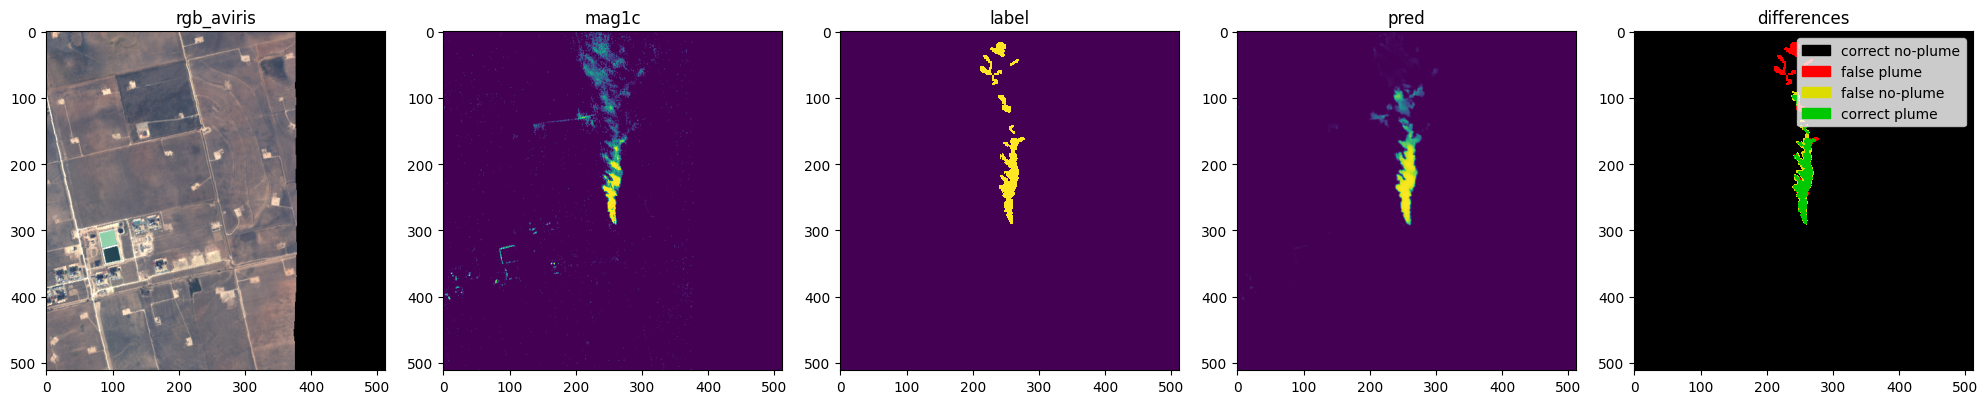

In [ ]:
dataloader = hsi_dm.test_dataloader(batch_size=1)
how_many = 1
for i, plume_data in enumerate(dataloader):
    plume_data = hsi_model.batch_with_preds(to_device(plume_data, hsi_model.device))
    fig = starcoplot.plot_batch(to_device(plume_data,"cpu"), input_products=hsi_config.dataset.input_products,
                                products_plot=hsi_config.products_plot, figsize_ax=(4, 4))

    plt.show(fig)
    plt.close()

    how_many -=1
    if how_many <= 0: break

In [ ]:
# from starcop.validation import run_validation
# dataloader = hsi_dm.test_dataloader(batch_size=1)
# hsi_metrics_per_id, hsi_metrics = run_validation(hsi_model, dataloader, products_plot=hsi_config.products_plot, verbose=True,
#                                           show_plots=True, skip_saving_plots=True, # < for showing
#                                           #show_plots=False, skip_saving_plots=False, # < for saving
#                                           path_save_results="hyperstarcop_outputs")

# # Note: The metrics on this small subset, don't make much sense

## MultiSTARCOP

In [ ]:
msi_model_path = "/content/multistarcop_varon/final_checkpoint_model.ckpt"
msi_config_path = "/content/multistarcop_varon/config.yaml"

msi_model, msi_dm, msi_config = load_model_with_datamodule(msi_model_path, msi_config_path)
print("Successfully loaded MultiSTARCOP model!")

Feature ratio_wv3_B7_B5_varon21_sum_c_out does not exists. It will be generated
Feature ratio_wv3_B8_B5_varon21_sum_c_out does not exists. It will be generated
Feature ratio_wv3_B7_B6_varon21_sum_c_out does not exists. It will be generated


100%|██████████| 9/9 [00:01<00:00,  4.60it/s]


Feature ratio_wv3_B7_B5_varon21_sum_c_out does not exists. It will be generated
Feature ratio_wv3_B8_B5_varon21_sum_c_out does not exists. It will be generated
Feature ratio_wv3_B7_B6_varon21_sum_c_out does not exists. It will be generated


100%|██████████| 9/9 [00:01<00:00,  4.94it/s]
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.7.7 to v2.0.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../multistarcop_varon/final_checkpoint_model.ckpt`
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 71.7MB/s]


Loaded model with 3 input channels, data module with 3 inputs: ['ratio_wv3_B7_B5_varon21_sum_c_out', 'ratio_wv3_B8_B5_varon21_sum_c_out', 'ratio_wv3_B7_B6_varon21_sum_c_out'] , for plotting we use these products: ['wv3_ratios_varon_b7b5', 'wv3_ratios_varon_b8b5', 'wv3_ratios_varon_b7b6', 'label', 'pred', 'differences']
Successfully loaded MultiSTARCOP model!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


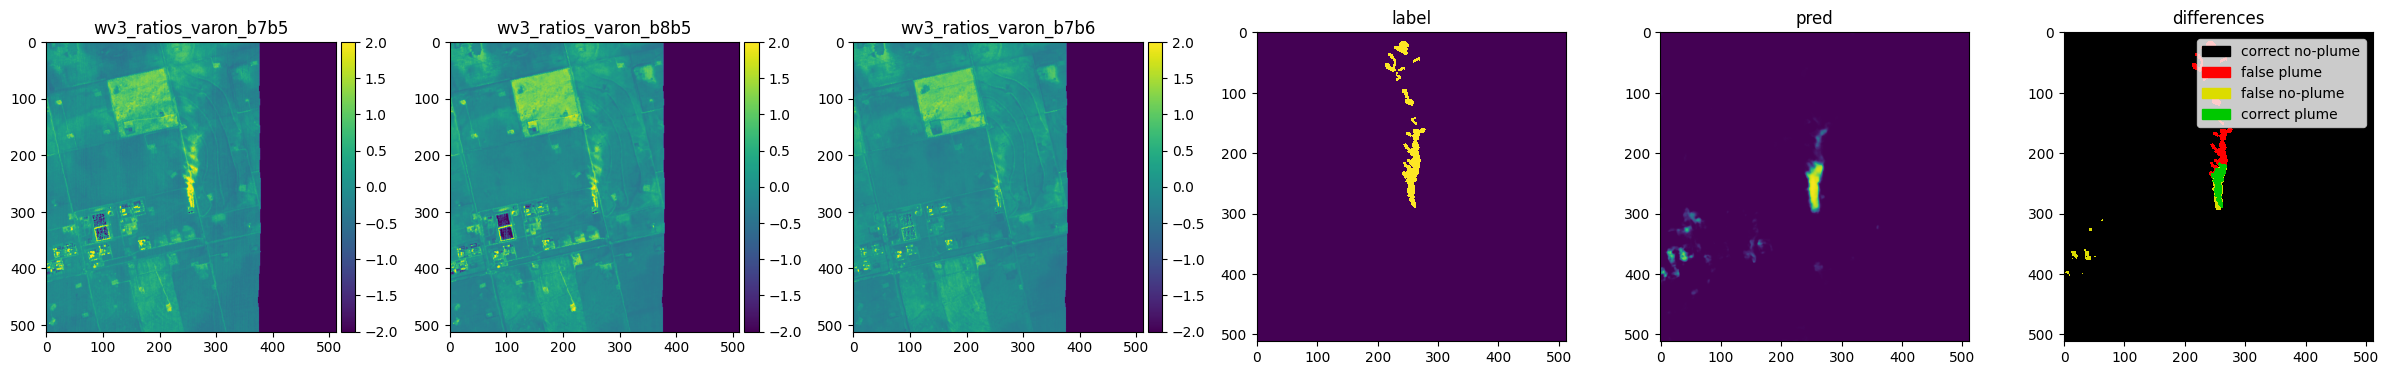

In [ ]:
dataloader = msi_dm.test_dataloader(batch_size=1)
how_many = 1
for i, plume_data in enumerate(dataloader):
    plume_data = msi_model.batch_with_preds(to_device(plume_data, msi_model.device))
    fig = starcoplot.plot_batch(to_device(plume_data,"cpu"), input_products=msi_config.dataset.input_products,
                                products_plot=msi_config.products_plot, figsize_ax=(4, 4))

    plt.show(fig)
    plt.close()

    how_many -=1
    if how_many <= 0: break


In [ ]:
# from starcop.validation import run_validation
# dataloader = msi_dm.test_dataloader(batch_size=1)
# msi_metrics_per_id, msi_metrics = run_validation(msi_model, dataloader, products_plot=msi_config.products_plot, verbose=True,
#                                           show_plots=True, skip_saving_plots=True, # < for showing
#                                           #show_plots=False, skip_saving_plots=False, # < for saving
#                                           path_save_results="multistarcop_outputs")

# # Note: The metrics on this small subset, don't make much sense